# **FDA_HW3-2**

In [0]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('online_shoppers_intention.csv')
data.loc[data['PageValues'] == 0, 'PV']=0
data.loc[(data['PageValues'] > 0) & (data['PageValues'] <= 10 ), 'PV']=1
data.loc[(data['PageValues'] > 10) & (data['PageValues'] <= 20 ), 'PV']=2
data.loc[(data['PageValues'] > 20) & (data['PageValues'] <= 30 ), 'PV']=3
data.loc[(data['PageValues'] > 30) & (data['PageValues'] <= 40 ), 'PV']=4
data.loc[(data['PageValues'] > 40) & (data['PageValues'] <= 50 ), 'PV']=5
data.loc[data['PageValues'] > 50, 'PV']=6

In [4]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,PV
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,0.0


# 資料集介紹
|Feature name|Feature description|
|--|--|
|Administrative|Number of pages visited by the visitor about account management|
|Administrative_Duration|Total amount of time(in seconds) spent by the visitor on account management related pages|
|Informational|Number of pages visited by the visitor about Web site, communiction and address information of the shopping site|
|Informational duration|Total amount of time(in seconds) spent by the visitor on informational pages|
|ProductRelated|Number of pages visited by visitor about product related pages|
|ProductRelated_Duration|Total amount of time(in seconds) spent by the visitor on product related pages|
|BounceRates|Average bounce rate value of the pages visited by the visitor|
|ExitRates|Average exit rate value of the pages visited by the visitor|
|PageValues|Average page value of the pages visited by the visitor|
|SpecialDay|Closeness of the site visiting time to a special day|
|OperatingSystems|Operating system of the visitor|
|Browser|Browser of the visitor|
|Region|Geographic region from which the session has been started by the visitor|
|TrafficType|Traffic source by which the visitor has arrived at the Web site|
|VisitorType|Visitor type as "New Visitor","Returning Visitor", and "Other"|
|Weekend|Boolean value indicating whether the date of the visit is weekend|
|Month|Month value of the visit day|
|Revenue|Class label indicating whether the visit has been finalized with a transaction|

# 目標
預測網站瀏覽者最後是否會進行商品的交易


列出詳細資料看有無缺失值



In [5]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
PV                         0
dtype: int64

Text(0.5, 1.0, 'Target')

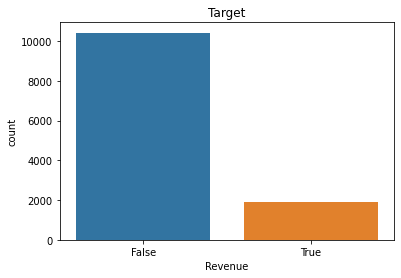

In [6]:
TargetDistr=data.groupby('Revenue').size()
sns.countplot(x="Revenue",data=data).set_title('Target')

# 資料分析

In [0]:
def PlotDistribution(feature):
    Buy = data[data['Revenue']==True][feature]
    NotBuy = data[data['Revenue']==False][feature]
    plt.title(feature)
    sns.distplot(Buy,hist=False,label='Buy')
    sns.distplot(NotBuy,hist=False,label='NotBuy')
    plt.legend()
    plt.show()

In [0]:
def bar_chart(feature):
    Buy = data[data['Revenue']==True][feature].value_counts()
    NotBuy = data[data['Revenue']==False][feature].value_counts()
    df = pd.DataFrame([Buy,NotBuy])
    df.index = ['Buy','NotBuy']
    if(feature == 'PV'):
      df.plot(kind='bar',stacked=True, figsize=(10,5), title='PageValues')
      col = ['0','0~10','10~20','20~30','30~40','40~50','>50']
      i = 0
      for column in df.columns:
        print(str(col[i])+' Buying rate:'+str(df.loc['Buy'][column]/df[column].sum()))
        i+=1      
    else:
      df.plot(kind='bar',stacked=True, figsize=(10,5), title=feature)
      for column in df.columns:
        print(str(column)+' Buying rate:'+str(df.loc['Buy'][column]/df[column].sum()))

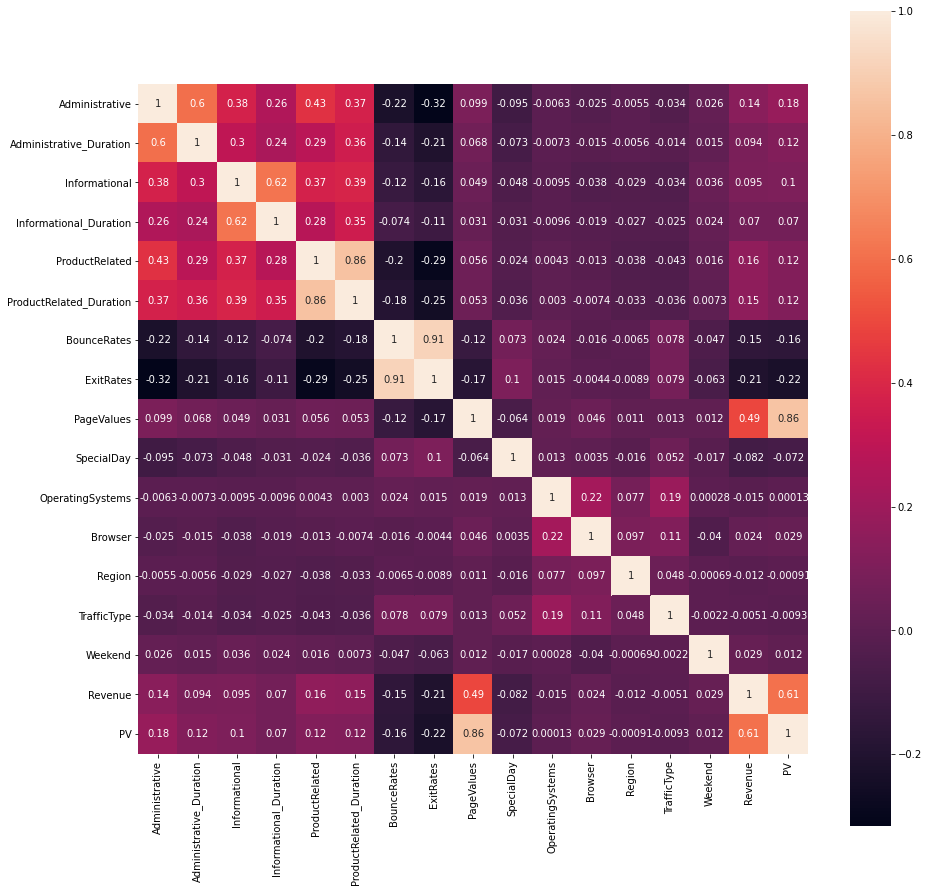

In [9]:
fig, ax = plt.subplots(figsize=(15, 15)) # 設定圖表大小
corr = data.corr()

sns.heatmap(corr,                      # 輸入資料給熱點圖，自動計算相關係數
            annot=True,                # 顯示每個格子所代表的數字
            square=True,               # 將格子形狀調整為正方形
            xticklabels=True,          # 顯示 x 軸座標標籤
            yticklabels=True,          # 顯示 y 軸座標標籤
            ax=ax)                     # 選擇畫圖的 Axes

plt.show()                             # 繪製圖表

由Heatmap圖可以看出各項feature與Revenue的相關程度，其中最為相關的前五項features分別是PageValues，再來是負相關的ExitRates與緊接在後的BounceRates，最後則是正相關的ProductRelated跟ProductRelated_Duration。

而最不相關的幾個則是Weekend,Browser,OperatingSystems,Region,TrafficType。


# 畫出前五重要feature的分布圖

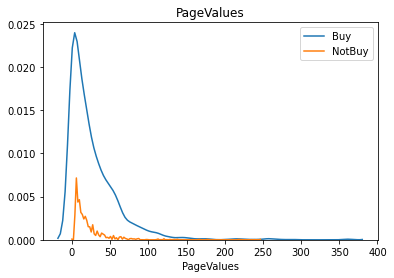

In [10]:
PlotDistribution('PageValues')	

0 Buying rate:0.03854166666666667
0~10 Buying rate:0.38362068965517243
10~20 Buying rate:0.5268987341772152
20~30 Buying rate:0.603988603988604
30~40 Buying rate:0.7261410788381742
40~50 Buying rate:0.7705882352941177
>50 Buying rate:0.8112745098039216


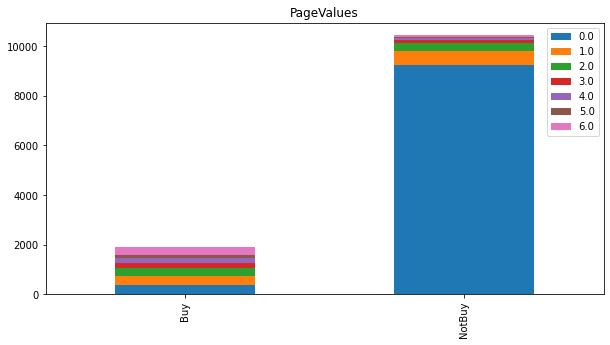

In [11]:
bar_chart('PV')

這裡我畫了兩種分析圖，可以看出當使用者瀏覽的頁面越多時，使用者會進行交易的比例越高，因此是一項很重要的feature。

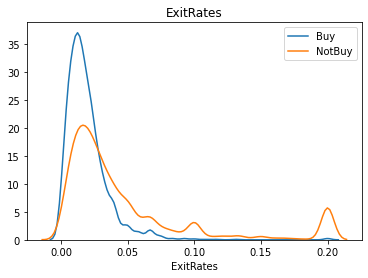

In [12]:
PlotDistribution('ExitRates')

可以看出不買的曲線明顯偏右，但是在ExitRates小於0.04之前，仍有滿多不買的使用者，這可能是會造成模型較難判斷的地方。

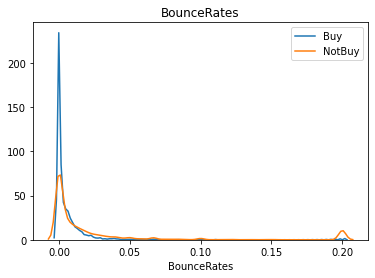

In [13]:
PlotDistribution('BounceRates')

這項feature的相關性雖然較高，但是從分布曲線來看買與不買的分布的範圍並沒有太大的差異。

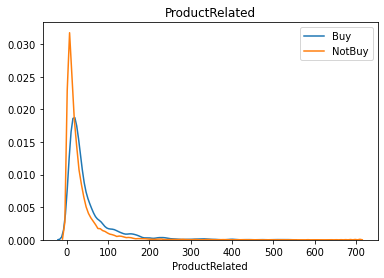

In [14]:
PlotDistribution('ProductRelated')

會買的人分布的曲線較往右偏，可知瀏覽越多與產品相關的頁面買的機率也會越高，但並沒有像PageValues一樣有顯著的差異。

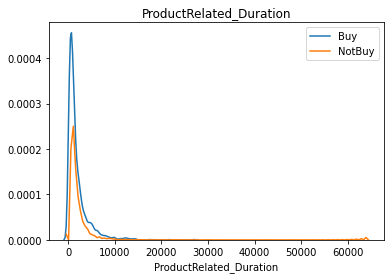

In [15]:
PlotDistribution('ProductRelated_Duration')

會買的人分布的曲線較往右偏，可知瀏覽與產品相關的頁面越久買的機率也會越高，但並沒有像PageValues一樣有顯著的差異。

In [0]:
Label = LabelEncoder()
data['Month'] = Label.fit_transform(data['Month'])
data['VisitorType'] = Label.fit_transform(data['VisitorType'])
data['Revenue'] = Label.fit_transform(data['Revenue'])
data['Weekend'] = Label.fit_transform(data['Weekend'])

In [0]:
X_train=data.drop(columns=['Revenue','PV'])
Y_train=data['Revenue']
np.random.seed(100)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 27)

In [0]:
from sklearn.metrics import plot_confusion_matrix
def PlotCM(model,x_test,y_test):
  fig, ax = plt.subplots(1, 1)
  disp = plot_confusion_matrix(
      model, x_test, y_test,
      normalize=None, 
      display_labels=['Not Buy', 'Buy'], 
      values_format='.0f', 
      ax=ax)


# 嘗試KNN模型 

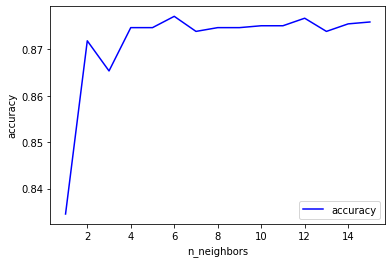

best_n_neighbors: 6
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2109
           1       0.72      0.25      0.37       357

    accuracy                           0.88      2466
   macro avg       0.80      0.62      0.65      2466
weighted avg       0.86      0.88      0.85      2466



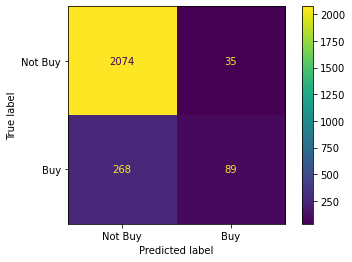

In [19]:
#knn model
results = []
n_neighbors_set = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for TryVal in n_neighbors_set:
  model = KNeighborsClassifier(n_neighbors = TryVal)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)


line1= plt.plot(n_neighbors_set, results, 'b', label="accuracy")
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()
best_n_neighbors = n_neighbors_set[results.index(max(results))]
print('best_n_neighbors:',best_n_neighbors)

model = KNeighborsClassifier(n_neighbors = best_n_neighbors)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)
PlotCM(model,x_test,y_test)


去找正確率最高的k值，得到的結果雖然正確率有0.88，但是看Buy(1)的Recall可以發現因為NotBuy的筆數遠高於Buy，模型並沒有學到太多真正有用的資訊，可能因為NotBuy的筆數太多了，造成KNN在k個最近的點下去投票時很容易就會是NotBuy佔多數。

# 嘗試Logistic Regression模型

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2109
           1       0.72      0.40      0.52       357

    accuracy                           0.89      2466
   macro avg       0.81      0.69      0.73      2466
weighted avg       0.88      0.89      0.88      2466



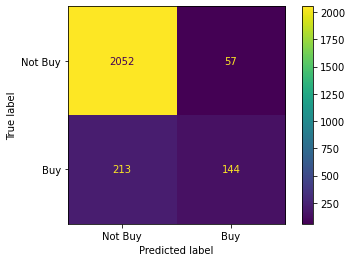

In [20]:
#Logistic Regression
model=LogisticRegression(dual=False,max_iter=4000,random_state=27, penalty='l2')
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)
PlotCM(model,x_test,y_test)

在Buy的Recall上有提升，整體正確率也提高至0.89，但因為Buy的Recall仍有進步空間因此繼續嘗試其他的模型。

# 嘗試MLP模型

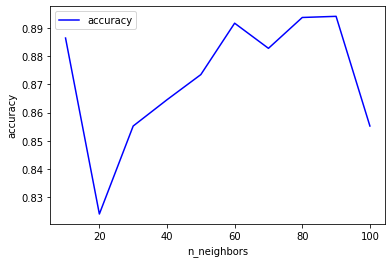

best_hidden_layer_size: 90
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2109
           1       0.66      0.56      0.61       357

    accuracy                           0.89      2466
   macro avg       0.79      0.76      0.77      2466
weighted avg       0.89      0.89      0.89      2466



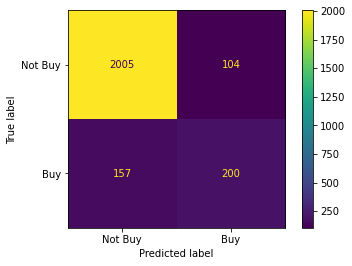

In [21]:
from sklearn.neural_network import MLPClassifier
results = []
hidden_layer_size = [10,20,30,40,50,60,70,80,90,100]
for TryVal in hidden_layer_size:
  model = MLPClassifier(hidden_layer_sizes=(TryVal,3),max_iter=200,random_state=27,batch_size=32)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)


line1= plt.plot(hidden_layer_size, results, 'b', label="accuracy")
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()
best_parameter = hidden_layer_size[results.index(max(results))]
print('best_hidden_layer_size:',best_parameter)


model = MLPClassifier(hidden_layer_sizes=(best_parameter,3),max_iter=200,random_state=27,batch_size=32)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)
PlotCM(model,x_test,y_test)

這邊我使用了不同隱藏層的size下去跑正確率最高的結果，準確率依舊是0.89，Buy的Recall則有提升至0.56，但是模型依舊無法很好的分類，因為雖然能預測出較多TP，但是FP也相對提高了。

# 嘗試Random Forest模型

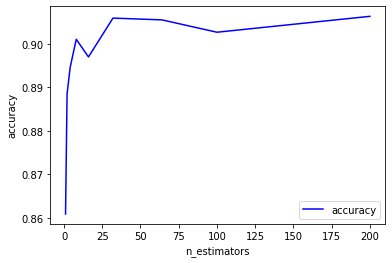

best_n_estimators: 200


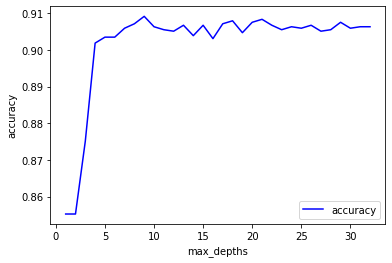

best_max_depth: 9
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2109
           1       0.73      0.59      0.65       357

    accuracy                           0.91      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.91      0.91      2466



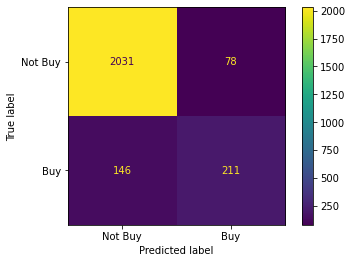

In [22]:
#RandomForest model
results=[]
n_estimators_set = [1, 2, 4, 8, 16, 32, 64, 100, 200]
for TryVal in n_estimators_set:
  model = RandomForestClassifier(n_estimators=TryVal,random_state=27)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)


line1= plt.plot(n_estimators_set, results, 'b', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend()
plt.show()
best_n_estimators = n_estimators_set[results.index(max(results))]
print('best_n_estimators:',best_n_estimators)

results = []   #Try different max_depth
max_depth_set = np.linspace(1, 32, 32, endpoint=True).astype(int)

for TryVal in max_depth_set:
  model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=TryVal,random_state=27)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)  

line1= plt.plot(max_depth_set, results, 'b', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('max_depths')
plt.legend()
plt.show()
best_max_depth = max_depth_set[results.index(max(results))]
print('best_max_depth:',best_max_depth)  

model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,random_state=27)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)
PlotCM(model,x_test,y_test)

準確率來到了0.91，且相較於MLP模型，Buy與NotBuy的recall都有提升。

# 嘗試Xgboost模型

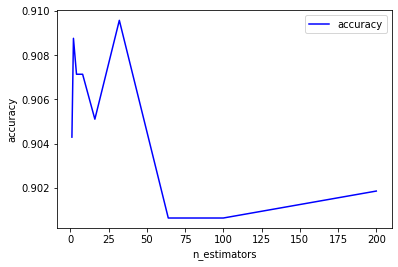

best_n_estimators: 32


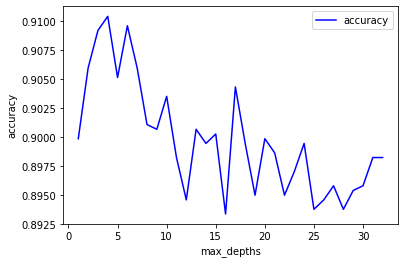

best_max_depth: 4
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2109
           1       0.71      0.64      0.67       357

    accuracy                           0.91      2466
   macro avg       0.83      0.80      0.81      2466
weighted avg       0.91      0.91      0.91      2466



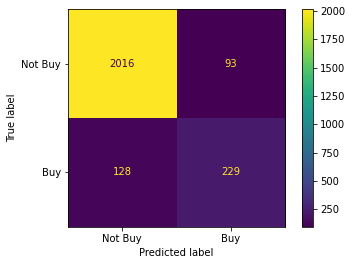

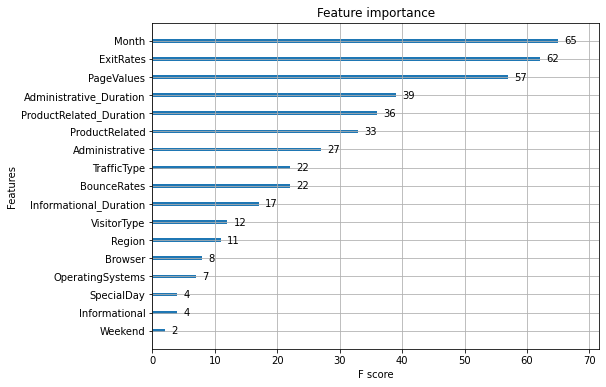

In [23]:
#Xgboost model
results = []   #Try different n_estimators
n_estimators_set = [1, 2, 4, 8, 16, 32, 64, 100, 200]
for TryVal in n_estimators_set:
  model = XGBClassifier(n_estimators=TryVal,random_state=27)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)


line1= plt.plot(n_estimators_set, results, 'b', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend()
plt.show()
best_n_estimators = n_estimators_set[results.index(max(results))]
print('best_n_estimators:',best_n_estimators)

results = []   #Try different max_depth
max_depth_set = np.linspace(1, 32, 32, endpoint=True).astype(int)

for TryVal in max_depth_set:
  model = XGBClassifier(n_estimators=best_n_estimators, max_depth=TryVal,random_state=27)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  acc = metrics.accuracy_score(y_pred,y_test)
  results.append(acc)  

line1= plt.plot(max_depth_set, results, 'b', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('max_depths')
plt.legend()
plt.show()
best_max_depth = max_depth_set[results.index(max(results))]
print('best_max_depth:',best_max_depth)  

model = XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,random_state=27)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)
PlotCM(model,x_test,y_test)

tryit = plot_importance(model)
tryit.figure.set_size_inches((8,6))


準確率依舊是0.91，但Buy的Recall有提升至0.64。

# 結論
看起來模型受到兩種類別筆數差異很大的情況有些嚴重，因為測試到最後Buy的recall依舊不高，幾種模型可能都還沒完全地根據feature學到非常有用的資訊，或許之後可以針對feature再做更深的分析，目前我有嘗試過把PageValues換成區間的方式丟入或是將相關性較低的feature拿掉看看，但是都會造成正確率下降。